**Installing Keras**

---


In [4]:
!pip install keras
!pip install keras_preprocessing
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


 **Imports**



---




In [5]:
import os
import sys
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers.core import Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten

from keras.models import Model
import re
from google.colab import drive

 **Imports**



---




In [6]:
!git clone https://github.com/bassantsamerr/ChatGPT_Sentiment_Analysis.git


Cloning into 'ChatGPT_Sentiment_Analysis'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), 27.36 MiB | 9.73 MiB/s, done.


In [7]:
%cd ChatGPT_Sentiment_Analysis/

/content/ChatGPT_Sentiment_Analysis


In [8]:
!unzip ezyzip.zip

Archive:  ezyzip.zip
  inflating: file.csv                


In [9]:
import pandas as pd
df = pd.read_csv('file.csv')
df.shape

(219294, 3)

**Imports for datapreprocessing**

---



In [10]:
#used in datapreprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
df.head(6)

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad
5,5,"Just launched ChatGPT, our new AI system which...",good


***Extract tweets and categories from data***

---



In [12]:
#get x
tweets = df['tweets'].values
tweets.shape

#get y
labels=df['labels'].values
labels.shape


(219294,)

**Convert good, bad ,neutral to numerical **

---



In [13]:

y_labels=labels

y_labels= np.array(list(map(lambda x: 1 if x=="good" else 0 if x=="bad" else 2, y_labels)))

print(y_labels.size)
y_labels


219294


array([2, 1, 2, ..., 0, 0, 2])

In [14]:
mapping = {1: "good", 0: "bad", 2: "natural"}

**Function of Data Cleaning**

---



In [15]:
#Basic Data Cleaning fucntion

def text_preprocess(processedTweet):
   
   # remove links
    processedTweet = re.sub(r'http\S+', ' ', processedTweet)
   
   # Remove punctuations and numbers
    processedTweet = re.sub('[^a-zA-Z]', ' ',processedTweet)

    # Single character removal
    processedTweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', processedTweet)

    # make it small
    processedTweet = processedTweet.lower()
    
    
      # to be abble to apply lemmatizer
    processedTweet = processedTweet.split()
    lemmatizer = WordNetLemmatizer()
    processedTweet = [lemmatizer.lemmatize(w) for w in processedTweet ]
    return ( " ".join(processedTweet))


**Apply Data Cleaning to dataset**




---



In [16]:
X_processed_Tweets = []
for i in range(len(tweets)):
    if text_preprocess(tweets[i]):
        X_processed_Tweets.append(text_preprocess(tweets[i]))
    else :
        y_labels= np.delete(y_labels, i)
        df = df.drop(i)

#X_procssed_Tweets    


    

**Initialize global params**

---



In [17]:
MAX_NUM_WORDS = 100000
maxLen=1000

Apply tokenization

---



In [18]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_processed_Tweets)

sequences = tokenizer.texts_to_sequences(X_processed_Tweets)
SVM_tweets=X_processed_Tweets



Apply padding

---



In [19]:

word_index = tokenizer.word_index # the dictionary
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxLen)
print('Shape of samples:', data.shape)
print('Sampele:(the zeros at the begining are for padding text to max length)')
print(data.shape )

Found 87343 unique tokens.
Shape of samples: (219289, 1000)
Sampele:(the zeros at the begining are for padding text to max length)
(219289, 1000)


**Prepare output for Models**

---



In [20]:
labels_matrix = to_categorical(np.asarray(y_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels_matrix.shape)
print('Sample label:\n',labels_matrix[1])

Shape of data tensor: (219289, 1000)
Shape of label tensor: (219289, 3)
Sample label:
 [0. 1. 0.]


**Split Data to train and test**

--- 

In [21]:
VALIDATION_SPLIT = 0.2
indices = np.arange(len(X_processed_Tweets))
np.random.shuffle(indices)
indices

data_shuffled = data[indices]
labels_shuffled = labels_matrix[indices]

num_test_samples = int(VALIDATION_SPLIT * data_shuffled.shape[0])


x_train = data_shuffled[:-num_test_samples]
y_train = labels_shuffled[:-num_test_samples]

x_test = data_shuffled[-num_test_samples:]
y_test = labels_shuffled[-num_test_samples:]

print('Shape of training data: ',x_train.shape)
print('Shape of testing data: ',x_test.shape)



Shape of training data:  (175432, 1000)
Shape of testing data:  (43857, 1000)


** save data in train and test files **

---



In [22]:
df2=df.drop(df.columns[0], axis=1)
df2=df2.iloc[indices]

print(df2.shape)

train_data_file=df2.iloc[:-num_test_samples]
test_data_file=df2.iloc[-num_test_samples:]
print(train_data_file.shape)
print(test_data_file.shape)

(219289, 2)
(175432, 2)
(43857, 2)


In [23]:
train_data_file.to_csv('train.csv', index=False)
test_data_file.to_csv('test.csv', index=False)

In [24]:
#used in word embedding
from numpy import array
from numpy import asarray
from numpy import zeros

**Load Glove**

---



In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-05-15 15:48:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-15 15:48:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-15 15:48:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [26]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [27]:
%ls

ChatGPT_sentiment_analysis.ipynb  glove.6B.200d.txt  README.md
ezyzip.zip                        glove.6B.300d.txt  test.csv
file.csv                          glove.6B.50d.txt   train.csv
glove.6B.100d.txt                 glove.6B.zip


**Extract data from Glov txt file**

---



In [28]:
EMBEDDING_DIM = 300
print('Indexing word vectors.')
embeddings_dictionary = {}
glove_file = open('glove.6B.300d.txt', encoding="utf8")
for line in glove_file:
    values = line.split(sep=' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
print('Found %s word vectors.' % len(embeddings_dictionary))

Indexing word vectors.
Found 400000 word vectors.


**Add Glov data to our dataset's words**

---



In [29]:
vocab_size = len(word_index) + 1
embedding_matrix = zeros((vocab_size, EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print ('Shape of Embedding Matrix: ',embedding_matrix.shape)


Shape of Embedding Matrix:  (87344, 300)


**Prepare embedding_layer**

---



In [31]:
embedding_layer = Embedding(vocab_size, #vocab size
EMBEDDING_DIM, #embedding vector size
weights=[embedding_matrix], #weights matrix
input_length=maxLen, #padded sequence length
trainable=False)
sequence_input = Input(shape=(1000,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

**CNN MODEL**

---



In [35]:
cnn_accuracies=[]

**CNN Model 1 (trial 1)**

---



In [ ]:
##### CNN Model 1 (trial 1)  #######
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(256, 5, activation='relu')(x)
x = MaxPooling1D(2)(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

cnn_model1 = Model(sequence_input, preds)
cnn_model1.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
print(cnn_model1.summary())

In [33]:
cnn_model1.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=7, batch_size=128)

Epoch 1/7
1371/1371 [==============================] - 115s 73ms/step - loss: 0.7752 - acc: 0.6706 - val_loss: 0.6702 - val_acc: 0.7316
Epoch 2/7
1371/1371 [==============================] - 101s 74ms/step - loss: 0.6399 - acc: 0.7478 - val_loss: 0.6281 - val_acc: 0.7521
Epoch 3/7
1371/1371 [==============================] - 102s 75ms/step - loss: 0.5818 - acc: 0.7760 - val_loss: 0.6152 - val_acc: 0.7612
Epoch 4/7
1371/1371 [==============================] - 101s 73ms/step - loss: 0.5379 - acc: 0.7952 - val_loss: 0.6443 - val_acc: 0.7526
Epoch 5/7
1371/1371 [==============================] - 101s 74ms/step - loss: 0.4979 - acc: 0.8123 - val_loss: 0.6594 - val_acc: 0.7592
Epoch 6/7
1371/1371 [==============================] - 100s 73ms/step - loss: 0.4602 - acc: 0.8285 - val_loss: 0.6767 - val_acc: 0.7547
Epoch 7/7
1371/1371 [==============================] - 99s 73ms/step - loss: 0.4275 - acc: 0.8416 - val_loss: 0.7066 - val_acc: 0.7540


In [36]:
score = cnn_model1.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
cnn_accuracies.append(score[1])

1371/1371 [==============================] - 12s 9ms/step - loss: 0.7066 - acc: 0.7540
Test Score: 0.7065912485122681
Test Accuracy: 0.753995954990387


**CNN Model 2 (trial 2)**

---



In [ ]:
##### CNN Model 2 (trial 2)  #######
x = Conv1D(128, 5, activation='relu', padding='same')(embedded_sequences)
x = MaxPooling1D(2)(x)

x = Conv1D(256, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(512, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(3, activation='softmax')(x)

cnn_model2 = Model(sequence_input, preds)
cnn_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(cnn_model2.summary())

In [38]:
cnn_model2.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=7, batch_size=128)

Epoch 1/7
1371/1371 [==============================] - 138s 98ms/step - loss: 0.5687 - acc: 0.7625 - val_loss: 0.4715 - val_acc: 0.8027
Epoch 2/7
1371/1371 [==============================] - 141s 103ms/step - loss: 0.3903 - acc: 0.8480 - val_loss: 0.3911 - val_acc: 0.8451
Epoch 3/7
1371/1371 [==============================] - 140s 102ms/step - loss: 0.3188 - acc: 0.8778 - val_loss: 0.3635 - val_acc: 0.8568
Epoch 4/7
1371/1371 [==============================] - 141s 103ms/step - loss: 0.2697 - acc: 0.8970 - val_loss: 0.3740 - val_acc: 0.8583
Epoch 5/7
1371/1371 [==============================] - 141s 103ms/step - loss: 0.2305 - acc: 0.9119 - val_loss: 0.4048 - val_acc: 0.8555
Epoch 6/7
1371/1371 [==============================] - 131s 96ms/step - loss: 0.1940 - acc: 0.9265 - val_loss: 0.3988 - val_acc: 0.8639
Epoch 7/7
1371/1371 [==============================] - 141s 103ms/step - loss: 0.1667 - acc: 0.9370 - val_loss: 0.4386 - val_acc: 0.8577


In [40]:
score = cnn_model2.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
cnn_accuracies.append(score[1])


1371/1371 [==============================] - 16s 11ms/step - loss: 0.4386 - acc: 0.8577
Test Score: 0.4386298656463623
Test Accuracy: 0.8576738238334656


**CNN Model 3 (trial 3)**

---



In [ ]:
##### CNN Model 3 (trial 3)  #######

x = Conv1D(128, 5, activation='relu', padding='same')(embedded_sequences)
x = MaxPooling1D(2)(x)

x = Conv1D(256, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(512, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(1024, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(3, activation='softmax')(x)

cnn_model3 = Model(sequence_input, preds)
cnn_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(cnn_model3.summary())


In [43]:
cnn_model3.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
1371/1371 [==============================] - 216s 155ms/step - loss: 0.5748 - acc: 0.7604 - val_loss: 0.4371 - val_acc: 0.8265
Epoch 2/6
1371/1371 [==============================] - 210s 153ms/step - loss: 0.3899 - acc: 0.8496 - val_loss: 0.3819 - val_acc: 0.8490
Epoch 3/6
1371/1371 [==============================] - 209s 153ms/step - loss: 0.3203 - acc: 0.8779 - val_loss: 0.3669 - val_acc: 0.8601
Epoch 4/6
1371/1371 [==============================] - 209s 153ms/step - loss: 0.2715 - acc: 0.8965 - val_loss: 0.3556 - val_acc: 0.8643
Epoch 5/6
1371/1371 [==============================] - 209s 152ms/step - loss: 0.2332 - acc: 0.9123 - val_loss: 0.3628 - val_acc: 0.8650
Epoch 6/6
1371/1371 [==============================] - 209s 152ms/step - loss: 0.1997 - acc: 0.9248 - val_loss: 0.3966 - val_acc: 0.8600


In [44]:
score = cnn_model3.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
cnn_accuracies.append(score[1])

1371/1371 [==============================] - 22s 16ms/step - loss: 0.3966 - acc: 0.8600
Test Score: 0.39664942026138306
Test Accuracy: 0.8599767684936523


**CNN Model 4 (trial 4)**

---



In [45]:

##### CNN Model 4 (trial 4)  #######
x = Conv1D(256, 5, activation='relu', padding='same')(embedded_sequences)
x = MaxPooling1D(2)(x)

x = Conv1D(512, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(1024, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)

x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

preds = Dense(3, activation='softmax')(x)

cnn_model4 = Model(sequence_input, preds)
cnn_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(cnn_model4.summary())


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 300)         26203200  
                                                                 
 conv1d_10 (Conv1D)          (None, 1000, 256)         384256    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 500, 256)         0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 500, 512)          655872    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 250, 512)         0         
 g1D)                                                      

In [46]:
cnn_model4.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=5, batch_size=128)

Epoch 1/5
1371/1371 [==============================] - 330s 236ms/step - loss: 0.5653 - acc: 0.7648 - val_loss: 0.4231 - val_acc: 0.8315
Epoch 2/5
1371/1371 [==============================] - 320s 233ms/step - loss: 0.3770 - acc: 0.8542 - val_loss: 0.3624 - val_acc: 0.8583
Epoch 3/5
1371/1371 [==============================] - 320s 233ms/step - loss: 0.3070 - acc: 0.8840 - val_loss: 0.3589 - val_acc: 0.8604
Epoch 4/5
1371/1371 [==============================] - 320s 233ms/step - loss: 0.2568 - acc: 0.9035 - val_loss: 0.3618 - val_acc: 0.8668
Epoch 5/5
1371/1371 [==============================] - 320s 233ms/step - loss: 0.2166 - acc: 0.9200 - val_loss: 0.3614 - val_acc: 0.8648


In [47]:
score = cnn_model4.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
cnn_accuracies.append(score[1])

1371/1371 [==============================] - 34s 25ms/step - loss: 0.3614 - acc: 0.8648
Test Score: 0.36144742369651794
Test Accuracy: 0.8647878170013428


**Plot Tirals & Accuracy Graph**

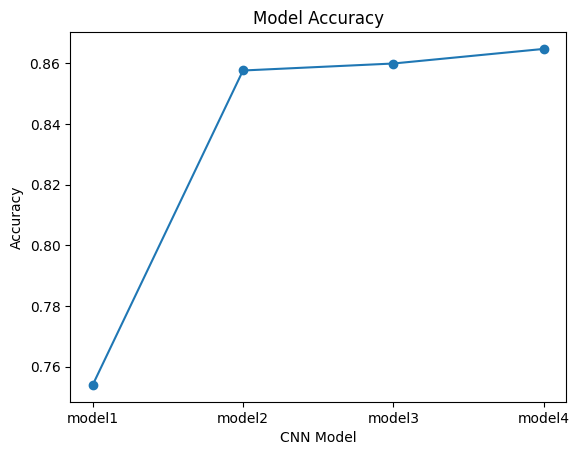

In [48]:
import matplotlib.pyplot as plt

# Create a bar chart to represent the accuracy
plt.plot(['model1','model2','model3','model4'], [cnn_accuracies[0],cnn_accuracies[1],cnn_accuracies[2],cnn_accuracies[3]],marker="o")
plt.xlabel('CNN Model')  # Set the label for the x-axis
plt.ylabel('Accuracy')  # Set the label for the y-axis
plt.title('Model Accuracy')  # Set the title for the chart

# Display the chart
plt.show()

**Test CNN model with user tweets good, bad and natural**

---



In [64]:
text=input("Your tweet: ")
test_preprocessed_text=text_preprocess(text)
test_row_text=[test_preprocessed_text]
test_text_sequence=tokenizer.texts_to_sequences(test_row_text)
test_padding_text=pad_sequences(test_text_sequence,maxlen=maxLen)
label_vector=cnn_model4.predict(test_padding_text[0].reshape(1,-1))
label_id=np.argmax(label_vector)
label_name=mapping.get(label_id)
print("Label:", label_name)

Your tweet: "Just had a conversation with ChatGPT, and it left me scratching my head. 🤔 Its responses were confusing, contradictory, and far from helpful. #ChatGPT #AI #Confused"
1/1 [==============================] - 0s 20ms/step
Label: bad


**LSTM Model**

---



In [57]:
accuracies=[]

**LSTM Model Model 1 (trial 1) **

---



In [ ]:
lstm_model1= Sequential()
lstm_model1.add(embedding_layer)
# While passing output to next LSTM layer set return_sequence to Ture.
lstm_model1.add(LSTM(64, return_sequences=True)) 
lstm_model1.add(LSTM(64, return_sequences=True)) 
lstm_model1.add(Dropout(0.2))
lstm_model1.add(Flatten())
lstm_model1.add(Dense(128, activation='relu'))
lstm_model1.add(Dropout(0.5))
lstm_model1.add(Dense(3, activation='sigmoid'))
lstm_model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
lstm_model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         26203200  
                                                                 
 lstm_6 (LSTM)               (None, 1000, 64)          93440     
                                                                 
 lstm_7 (LSTM)               (None, 1000, 64)          33024     
                                                                 
 dropout_3 (Dropout)         (None, 1000, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 64000)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               8192128   
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [ ]:
lstm_model1.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
1371/1371 [==============================] - 129s 92ms/step - loss: 0.6862 - accuracy: 0.7049 - val_loss: 0.4936 - val_accuracy: 0.8042
Epoch 2/6
1371/1371 [==============================] - 139s 101ms/step - loss: 0.4607 - accuracy: 0.8222 - val_loss: 0.3813 - val_accuracy: 0.8512
Epoch 3/6
1371/1371 [==============================] - 136s 99ms/step - loss: 0.3614 - accuracy: 0.8656 - val_loss: 0.3300 - val_accuracy: 0.8741
Epoch 4/6
1371/1371 [==============================] - 137s 100ms/step - loss: 0.3100 - accuracy: 0.8864 - val_loss: 0.2948 - val_accuracy: 0.8952
Epoch 5/6
1371/1371 [==============================] - 137s 100ms/step - loss: 0.2779 - accuracy: 0.8990 - val_loss: 0.2807 - val_accuracy: 0.9019
Epoch 6/6
1371/1371 [==============================] - 137s 100ms/step - loss: 0.2555 - accuracy: 0.9080 - val_loss: 0.2697 - val_accuracy: 0.9009


In [ ]:
score = lstm_model1.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
accuracies.append(score)

1371/1371 [==============================] - 35s 25ms/step - loss: 0.2697 - accuracy: 0.9009
Test Score: 0.26972708106040955
Test Accuracy: 0.9008824229240417


**LSTM Model 2 (Best Model) **

---



In [54]:
lstm_model2 = Sequential()
lstm_model2.add(embedding_layer)
# While passing output to next LSTM layer set return_sequence to Ture.
lstm_model2.add(LSTM(128, return_sequences=True)) 
lstm_model2.add(LSTM(128))
lstm_model2.add(Dense(32, activation='relu'))
lstm_model2.add(Dense(3, activation='softmax'))
lstm_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         26203200  
                                                                 
 lstm (LSTM)                 (None, 1000, 128)         219648    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_9 (Dense)             (None, 32)                4128      
                                                                 
 dense_10 (Dense)            (None, 3)                 99        
                                                                 
Total params: 26,558,659
Trainable params: 355,459
Non-trainable params: 26,203,200
_________________________________________________________________


In [55]:
lstm_model2.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
1371/1371 [==============================] - 217s 154ms/step - loss: 0.5730 - accuracy: 0.7577 - val_loss: 0.4069 - val_accuracy: 0.8413
Epoch 2/6
1371/1371 [==============================] - 214s 156ms/step - loss: 0.3457 - accuracy: 0.8688 - val_loss: 0.3080 - val_accuracy: 0.8865
Epoch 3/6
1371/1371 [==============================] - 213s 155ms/step - loss: 0.2715 - accuracy: 0.8989 - val_loss: 0.2681 - val_accuracy: 0.9005
Epoch 4/6
1371/1371 [==============================] - 210s 153ms/step - loss: 0.2289 - accuracy: 0.9158 - val_loss: 0.2529 - val_accuracy: 0.9077
Epoch 5/6
1371/1371 [==============================] - 211s 154ms/step - loss: 0.1966 - accuracy: 0.9289 - val_loss: 0.2448 - val_accuracy: 0.9130
Epoch 6/6
1371/1371 [==============================] - 211s 154ms/step - loss: 0.1701 - accuracy: 0.9384 - val_loss: 0.2371 - val_accuracy: 0.9155


In [58]:
score = lstm_model2.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
accuracies.append(score)

1371/1371 [==============================] - 38s 28ms/step - loss: 0.2371 - accuracy: 0.9155
Test Score: 0.23714469373226166
Test Accuracy: 0.9155436754226685


**LSTM Model Model 3 (trial 3) **

---



In [ ]:
lstm_model3 = Sequential()
lstm_model3.add(embedding_layer)
# While passing output to next LSTM layer set return_sequence to Ture.
lstm_model3.add(LSTM(128, return_sequences=True)) 
lstm_model3.add(LSTM(128))
lstm_model3.add(Dense(32, activation='relu'))
lstm_model1.add(Dropout(0.2))
lstm_model1.add(Flatten())
lstm_model3.add(Dense(3, activation='softmax'))
lstm_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model3.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         26203200  
                                                                 
 lstm_13 (LSTM)              (None, 1000, 128)         219648    
                                                                 
 lstm_14 (LSTM)              (None, 128)               131584    
                                                                 
 dense_13 (Dense)            (None, 32)                4128      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 26,558,659
Trainable params: 355,459
Non-trainable params: 26,203,200
_________________________________________________________________


In [ ]:
lstm_model3.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
1371/1371 [==============================] - 202s 144ms/step - loss: 0.5503 - accuracy: 0.7691 - val_loss: 0.3881 - val_accuracy: 0.8525
Epoch 2/6
1371/1371 [==============================] - 204s 149ms/step - loss: 0.3233 - accuracy: 0.8797 - val_loss: 0.2901 - val_accuracy: 0.8908
Epoch 3/6
1371/1371 [==============================] - 212s 155ms/step - loss: 0.2528 - accuracy: 0.9073 - val_loss: 0.2547 - val_accuracy: 0.9070
Epoch 4/6
1371/1371 [==============================] - 213s 155ms/step - loss: 0.2138 - accuracy: 0.9226 - val_loss: 0.2432 - val_accuracy: 0.9121
Epoch 5/6
1371/1371 [==============================] - 214s 156ms/step - loss: 0.1832 - accuracy: 0.9343 - val_loss: 0.2406 - val_accuracy: 0.9137
Epoch 6/6
1371/1371 [==============================] - 215s 157ms/step - loss: 0.1604 - accuracy: 0.9433 - val_loss: 0.2473 - val_accuracy: 0.9150


In [ ]:
score = lstm_model3.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
accuracies.append(score)

1371/1371 [==============================] - 38s 28ms/step - loss: 0.2473 - accuracy: 0.9150
Test Score: 0.24729467928409576
Test Accuracy: 0.9149508476257324


**LSTM Model 4 (trial 4) **

---



In [ ]:
lstm_model4 = Sequential()
lstm_model4.add(embedding_layer)
# While passing output to next LSTM layer set return_sequence to Ture.
lstm_model4.add(LSTM(256, return_sequences=True)) 
lstm_model4.add(LSTM(256))
lstm_model4.add(Dense(64, activation='relu'))
lstm_model4.add(Dropout(0.3))
lstm_model4.add(Flatten())
lstm_model4.add(Dense(3, activation='softmax'))
lstm_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         26203200  
                                                                 
 lstm_15 (LSTM)              (None, 1000, 256)         570368    
                                                                 
 lstm_16 (LSTM)              (None, 256)               525312    
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 3)                

In [ ]:
lstm_model4.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
1371/1371 [==============================] - 470s 340ms/step - loss: 0.5433 - accuracy: 0.7769 - val_loss: 0.3683 - val_accuracy: 0.8592
Epoch 2/6
1371/1371 [==============================] - 474s 346ms/step - loss: 0.3133 - accuracy: 0.8856 - val_loss: 0.2838 - val_accuracy: 0.8953
Epoch 3/6
1371/1371 [==============================] - 479s 350ms/step - loss: 0.2433 - accuracy: 0.9131 - val_loss: 0.2465 - val_accuracy: 0.9110
Epoch 4/6
1371/1371 [==============================] - 461s 336ms/step - loss: 0.2011 - accuracy: 0.9288 - val_loss: 0.2275 - val_accuracy: 0.9188
Epoch 5/6
1371/1371 [==============================] - 459s 334ms/step - loss: 0.1681 - accuracy: 0.9401 - val_loss: 0.2343 - val_accuracy: 0.9178
Epoch 6/6
1371/1371 [==============================] - 456s 332ms/step - loss: 0.1396 - accuracy: 0.9506 - val_loss: 0.2510 - val_accuracy: 0.9157


In [ ]:
score = lstm_model4.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
accuracies.append(score)

1371/1371 [==============================] - 65s 48ms/step - loss: 0.2510 - accuracy: 0.9157
Test Score: 0.25095334649086
Test Accuracy: 0.9157488942146301


In [ ]:
accuracies

[[0.26972708106040955, 0.9008824229240417],
 [0.2364325374364853, 0.9162733554840088],
 [0.24729467928409576, 0.9149508476257324],
 [0.25095334649086, 0.9157488942146301]]

**Plot Tirals & Accuracy Graph**

---



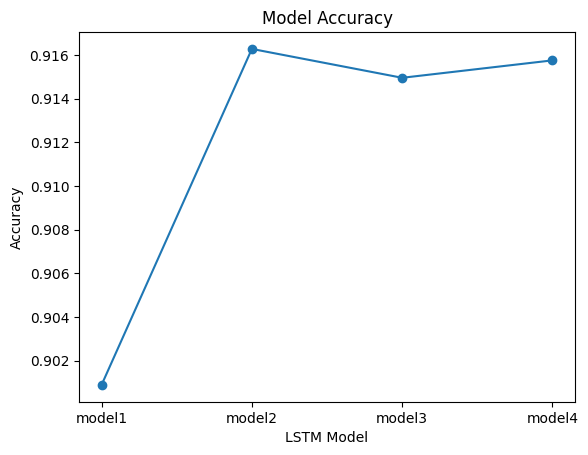

In [65]:
import matplotlib.pyplot as plt

# Create a bar chart to represent the accuracy
plt.plot(['model1','model2','model3','model4'], [accuracies[0][1],accuracies[1][1],accuracies[2][1],accuracies[3][1]],marker="o")
plt.xlabel('LSTM Model')  # Set the label for the x-axis
plt.ylabel('Accuracy')  # Set the label for the y-axis
plt.title('Model Accuracy')  # Set the title for the chart

# Display the chart
plt.show()

**Test LSTM model with user tweets good, bad and natural**

---



In [63]:
text=input("Your tweet: ")
test_preprocessed_text=text_preprocess(text)
test_row_text=[test_preprocessed_text]
test_text_sequence=tokenizer.texts_to_sequences(test_row_text)
test_padding_text=pad_sequences(test_text_sequence,maxlen=maxLen)
label_vector=lstm_model2.predict(test_padding_text[0].reshape(1,-1))
label_id=np.argmax(label_vector)
label_name=mapping.get(label_id)
print("Label:", label_name)

Your tweet: "Just had a conversation with ChatGPT, and it left me scratching my head. 🤔 Its responses were confusing, contradictory, and far from helpful. #ChatGPT #AI #Confused"
1/1 [==============================] - 0s 38ms/step
Label: bad
